# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from helpers.dataloader_custom_functions import collate_fn
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner

# Loading data

In [2]:
df_train = pd.read_csv('../data/train-leave2.csv')
df_val = pd.read_csv('../data/val-leave2.csv')
df_test = pd.read_csv('../data/test-leave2.csv')
index_manager = IndexManager()
index_manager.load('../data/index.pkl')

# Tuning model

In [3]:
unique_users = index_manager.get_indexed_values('user_id')
unique_items = index_manager.get_indexed_values('item_id')

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
)

In [4]:
param_grid = {
            'factors': [16, 32, 64, 128],
            'mlp_user_item_dim': [32, 64, 128],
            'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
            'epochs': [50],
            'optimizer': ['adagrad', 'adam'], # Removed SGD
            'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
            'weight_decay': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
            'loss_fn': ['mse', 'bce'],
            'batch_size': [2048, 4096, 8192, 16384, 32768],
}

tuner.set_param_grid(param_grid)

In [5]:
results, file_path = tuner.perform_random_search(num_trials=30, result_file='tuning_results/baseline-tuning-1.json')

Running experiment with params: {'factors': 64, 'mlp_user_item_dim': 64, 'learning_rate': 0.01, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.4, 'weight_decay': 0.01, 'loss_fn': 'bce', 'batch_size': 4096}
Epoch 1/50
Train loss: 0.555136, Validation loss: 0.638010
Epoch 2/50
Train loss: 0.517643, Validation loss: 0.638559
Epoch 3/50
Train loss: 0.512823, Validation loss: 0.640806
Epoch 4/50
Train loss: 0.510662, Validation loss: 0.642041
Epoch 5/50
Train loss: 0.509576, Validation loss: 0.643564
Epoch 6/50
Train loss: 0.508803, Validation loss: 0.643972
Early stopping triggered after 6 epochs
Training completed!
Creating ground truth sets...
Generating predictions...
Processing 1 of 121682 users... (0.00%)
Memory usage: 0.306396484375
Increased user batch size from 256 to 282
Increased item batch size from 2048 to 2253
Processing 257 of 121682 users... (0.21%)
Memory usage: 0.344482421875
Increased user batch size from 282 to 310
Increased item batch size from 2253 to 2478
Processi

In [13]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 64, 'mlp_user_item_dim': 32, 'learning_rate': 0.001, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.1, 'weight_decay': 0.01, 'loss_fn': 'bce', 'batch_size': 4096}, 'value': 0.042972666458473724}, 'NDCG@10': {'params': {'factors': 64, 'mlp_user_item_dim': 32, 'learning_rate': 0.001, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.1, 'weight_decay': 0.01, 'loss_fn': 'bce', 'batch_size': 4096}, 'value': 0.020883750696864226}, 'Recall@10': {'params': {'factors': 64, 'mlp_user_item_dim': 32, 'learning_rate': 0.001, 'epochs': 50, 'optimizer': 'adagrad', 'dropout': 0.1, 'weight_decay': 0.01, 'loss_fn': 'bce', 'batch_size': 4096}, 'value': 0.042972666458473724}}


# Analyzing results

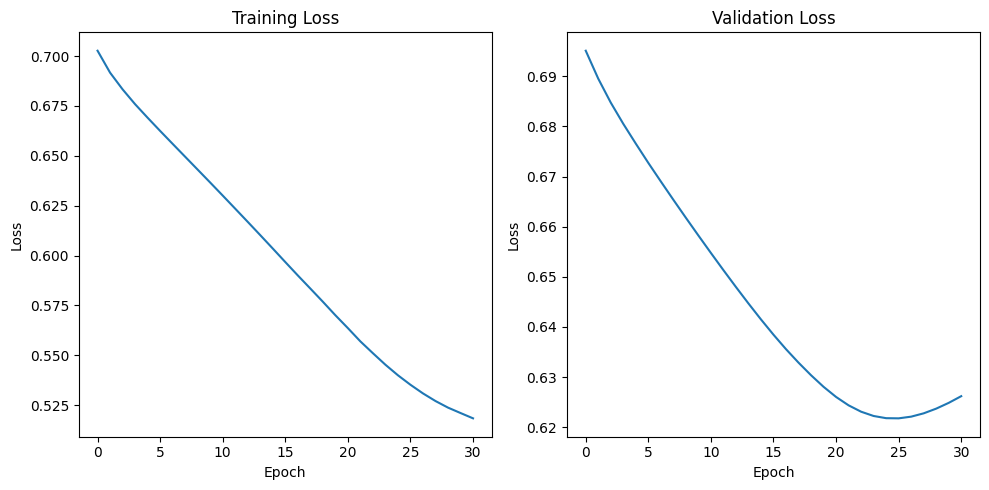

In [7]:
df_result = tuner.plot_results()

In [12]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,Hit Ratio@10,NDCG@10,Recall@10
0,64,32,0.0100,50,adam,0.5,0.0010,mse,16384,0.001742,0.001568,0.001742
1,32,128,0.1000,50,sgd,0.0,0.0005,bpr,2048,0.000148,0.000061,0.000148
2,128,32,0.0010,50,sgd,0.5,0.1000,bce,32768,0.000107,0.000045,0.000107
3,64,64,0.0010,50,adagrad,0.0,0.0001,bpr,2048,0.040680,0.017805,0.040680
4,64,32,0.0100,50,adagrad,0.5,0.1000,mse,4096,0.001742,0.001568,0.001742
5,16,64,0.0005,50,adam,0.5,0.1000,mse,32768,0.001742,0.001568,0.001742
6,16,64,0.1000,50,sgd,0.5,0.0001,bce,16384,0.000058,0.000022,0.000058
7,32,64,0.0001,50,adam,0.2,0.0001,mse,16384,0.040121,0.020304,0.040121
8,16,32,0.1000,50,sgd,0.2,0.0010,bce,16384,0.000156,0.000072,0.000156
9,32,64,0.0500,50,sgd,0.5,0.0010,mse,32768,0.000107,0.000042,0.000107


# Train model with best params

In [9]:
best_param = best_params['Hit Ratio@10']['params']

train_dataset = NCFDataset(df_train)
val_dataset = NCFDataset(df_val)

dataloader_params = {
    'batch_size': best_param.pop('batch_size'),
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 4,
    'pin_memory': True,
    'pin_memory_device': 'cuda',
    'collate_fn': collate_fn
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_dataloader = DataLoader(val_dataset, shuffle=False, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, **best_param)
model.fit(train_dataloader, val_dataloader)

evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Epoch 1/50
Train loss: 0.698732, Validation loss: 0.694136
Epoch 2/50
Train loss: 0.692056, Validation loss: 0.690949
Epoch 3/50
Train loss: 0.687425, Validation loss: 0.688350
Epoch 4/50
Train loss: 0.683441, Validation loss: 0.686069
Epoch 5/50
Train loss: 0.679873, Validation loss: 0.684002
Epoch 6/50
Train loss: 0.676577, Validation loss: 0.682093
Epoch 7/50
Train loss: 0.673504, Validation loss: 0.680305
Epoch 8/50
Train loss: 0.670554, Validation loss: 0.678610
Epoch 9/50
Train loss: 0.667774, Validation loss: 0.676992
Epoch 10/50
Train loss: 0.665071, Validation loss: 0.675435
Epoch 11/50
Train loss: 0.662455, Validation loss: 0.673929
Epoch 12/50
Train loss: 0.659893, Validation loss: 0.672461
Epoch 13/50
Train loss: 0.657376, Validation loss: 0.671023
Epoch 14/50
Train loss: 0.654905, Validation loss: 0.669609
Epoch 15/50
Train loss: 0.652420, Validation loss: 0.668209
Epoch 16/50
Train loss: 0.649978, Validation loss: 0.666817
Epoch 17/50
Train loss: 0.647531, Validation loss

In [11]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0431042
NDCG@10:	 0.0205421
Recall@10:	 0.0431042
